# Plotting Glider data with Python tools

Quick demo on how to obtain, and plot glider data with [`iris`](http://scitools.org.uk/iris/docs/latest/index.html) and cartopy.

In this notebook we will explore data from the [`RU22`](https://marine.rutgers.edu/cool/auvs/index.php) glider from RUTGERS. The data are served on [`THREDDS`](http://www.unidata.ucar.edu/software/thredds/current/tds/) via [`OPeNDAP`](https://www.opendap.org/).

In [1]:
url = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/glider/mab/Gridded/20101025T1600_marcoos_ru22_active.nc'

In [2]:
import iris


glider = iris.load(url)


x = glider.extract_strict('Longitude').data
y = glider.extract_strict('Latitude').data
z = glider.extract_strict('Temperature').coord('depth').points
t = glider.extract_strict('Temperature').coord('time')
t = t.units.num2date(t.points)

temp = glider.extract_strict('Temperature').data
sal = glider.extract_strict('Salinity').data

/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1686: UserWarning: Ignoring netCDF variable 'BB532' invalid units 'inverse meters'
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1686: UserWarning: Ignoring netCDF variable 'salinity' invalid units 'psu'
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.

`Iris` is a very strict `CF-1.6` data model and that is why we see those warnings regarding invalid units. If the data is not CF at all `iris` will refuse to load it!

Glider data is not something trivial to visualize. The very first thing to do is to plot the glider track to check its patch.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(5, 11),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(LAND, zorder=0)
    ax.coastlines('10m', zorder=1)
    return fig, ax

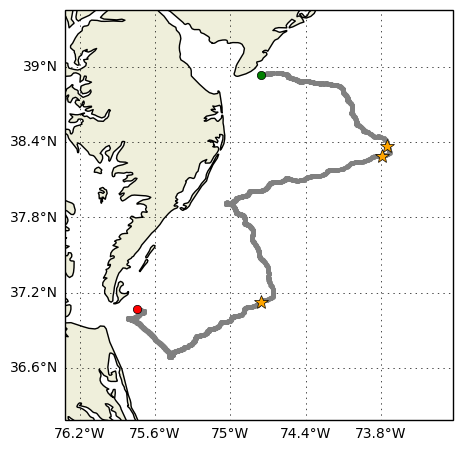

In [4]:
fig, ax = make_map()

ax.plot(x, y, '.-', color='gray', alpha=0.75)
ax.plot(x[0], y[0], marker='o', color='green')  # Start.
ax.plot(x[-1], y[-1], marker='o', color='red')  # Finish.

# The three deepst dives.
kw = dict(marker='*', color='orange', markersize=10)
ax.plot(x[732], y[732], **kw)
ax.plot(x[754], y[754], **kw)
ax.plot(x[1785], y[1785], **kw)

dx = dy = 0.5
ax.set_extent([x.min()-dx, x.max()+dx, y.min()-dy, y.max()+dy])

One might be interested in a the individual profiles of each dive.
Lets extract the first three deepest dives temperature/

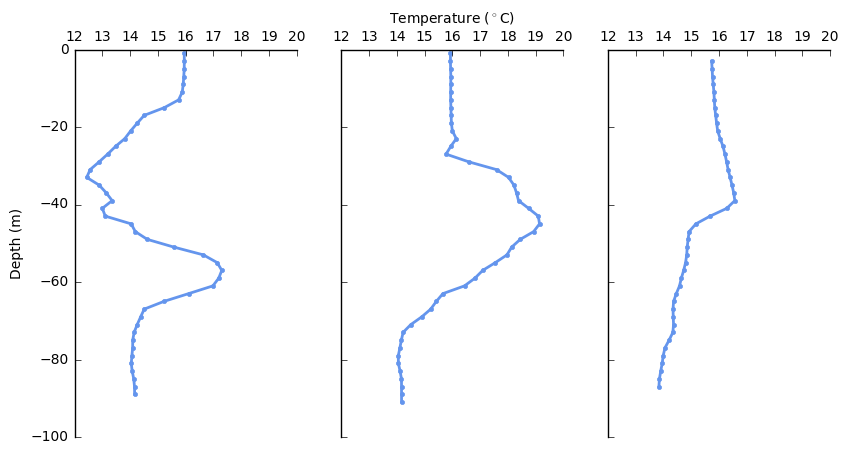

In [5]:
ncols = 3
fig, (ax0, ax1, ax2) = plt.subplots(
    sharey=True, sharex=True, ncols=ncols, figsize=(3.25*ncols, 5)
)

kw = dict(linewidth=2, color='cornflowerblue', marker='.')
ax0.plot(temp[732], z, **kw)
ax1.plot(temp[754], z, **kw)
ax2.plot(temp[1785], z, **kw)


def spines(ax):
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')

[spines(ax) for ax in (ax0, ax1, ax2)]

ax0.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Temperature ($^\circ$C)')
ax1.xaxis.set_label_position('top')

Glider cross-section also very be useful but we need to be careful when interpreting those due to the many turns the glider took.

In [6]:
import numpy as np
import seawater as sw
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def distance(x, y, units='km'):
    dist, pha = sw.dist(x, y, units=units)
    return np.r_[0, np.cumsum(dist)]


def plot_glider(x, y, z, t, data, cmap=plt.cm.viridis,
                figsize=(9, 3.75), track_inset=False):

    fig, ax = plt.subplots(figsize=figsize)
    dist = distance(x, y, units='km')
    z = np.abs(z)
    dist, z = np.broadcast_arrays(dist[..., np.newaxis], z)
    cs = ax.pcolor(dist, z, data, cmap=cmap, snap=True)
    kw = dict(orientation='vertical', extend='both', shrink=0.65)
    cbar = fig.colorbar(cs, **kw)

    if track_inset:
        axin = inset_axes(ax, width="25%", height="30%", loc=4)
        axin.plot(x, y, 'k.')
        start, end = (x[0], y[0]), (x[-1], y[-1])
        kw = dict(marker='o', linestyle='none')
        axin.plot(*start, color='g', **kw)
        axin.plot(*end, color='r', **kw)
        axin.axis('off')

    ax.invert_yaxis()
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Depth (m)')
    title = '{0:%Y-%m-%d %H:%M:%S} to {1:%Y-%m-%d %H:%M:%S}'.format
    ax.set_title(title(t[0], t[-1]).format(t[0], t[-1]))
    return fig, ax, cbar

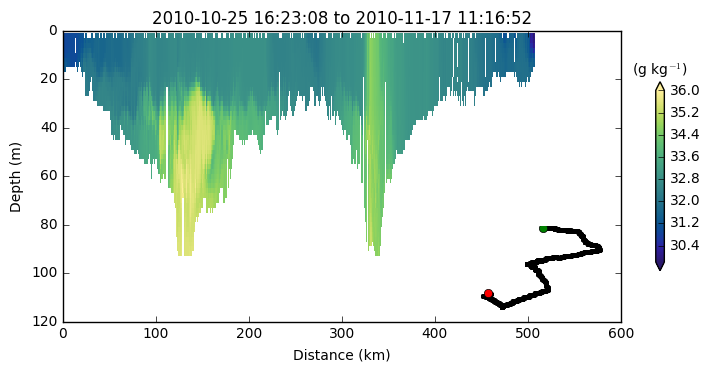

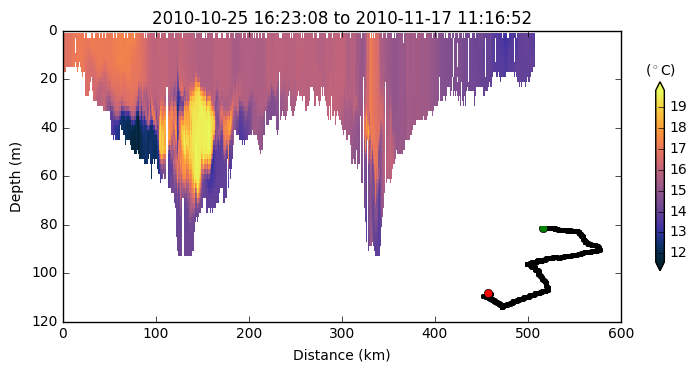

In [7]:
import cmocean

fig, ax, cbar = plot_glider(x, y, z, t, sal,
                            cmap=cmocean.cm.haline, track_inset=True)
cbar.ax.set_xlabel(r'(g kg$^{-1}$)')
cbar.ax.xaxis.set_label_position('top')

fig, ax, cbar = plot_glider(x, y, z, t, temp,
                            cmap=cmocean.cm.thermal, track_inset=True)
cbar.ax.set_xlabel(r'($^\circ$C)')
cbar.ax.xaxis.set_label_position('top')

Glider cross-section also very be useful but we need to be careful when interpreting those due to the many turns the glider took,
and the time it took to complete the track.

Note that the `x-axis` can be either time or distance. Note that this particular track took 22 days to complete!